# load package

In [1]:
import emcee

from multiprocessing import Pool
import numpy as np
from scipy.special import erf
import corner
from IPython.display import display, Math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns
sns.set(font_scale=2)
# sns.set(rc={'figure.figsize':(15.7,9.27)})
sns.set_style("ticks")

In [3]:
rvir = 643.4968999301032/1000

# LOAD data

In [4]:
# -*- coding:utf-8 -*-

ms = [11.3,11.5]
ml = [9.0,9.5,10.0,10.5]
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)

mass0 = np.concatenate((np.ones(16)*9.25,np.ones(16)*9.75,np.ones(16)*10.25,np.ones(16)*10.75))
mass0 = mass0.reshape(-1,16)


data = np.zeros((len(ms)-1,len(ml),3,16))
for i in range(len(ms)-1):
    for j in range(len(ml)):
        if j==0:
            red = np.load("./normal_fra_red_new_cor/%.1f_%.1f.npy"% (ms[i]+0.1,ml[j]))
            data[i][j] = red
        else:
            red = np.load("./normal_fra_red_cor/%.1f_%.1f.npy"% (ms[i]+0.1,ml[j]))
            data[i][j] = red

rtest = np.concatenate((data[0][::,0]))
datatest = np.concatenate((data[0][::,1]))
sigtest = np.concatenate((data[0][::,2]))
masstest = np.concatenate((mass0))

## fitting formula

In [5]:
def func(X,a,b,c,d):
    r,m = X
    y = (a*m+b) * (1-erf(r-rvir)) + c*m+d
    return y

In [153]:
def func(X,a,b,c,d):
    r,m = X
    y = (a*m+b) * (1-erf((r-rvir)/rvir)) + c*m+d
    return y

## new fitting

In [5]:
def func(X,b,d):
    r,m = X
    y = (-0.12*m+b) * (1-erf(r-rvir)) + 0.4*m+d
    return y

In [6]:
def log_likelihood(theta,X,data,data_err):
    a,b,c,d = theta
    r,m = X
    model = func(X,a,b,c,d)
    sigma2 = data_err ** 2
    chi2 = np.sum((data-model)**2 / sigma2)
#     sigma2 = data_err[32:] ** 2
#     chi2 = np.sum((data[32:]-model[32:])**2 / sigma2)
    ll = -0.5 * chi2

    if not np.isfinite(ll):
        return (-np.inf,) + (np.inf)
    if np.isnan(ll):
        return (-np.inf,) + (np.inf)
    out = (ll,) + (chi2,)
    return out

In [7]:
def log_prior(theta):
    a,b,c,d = theta
    if a<0.0 and 0.0<b and 0.0<c<1.0 and -10<d<10:
        return 0.0
    return -np.inf

In [8]:
def log_probability(theta,X,data,data_err):
    a,b,c,d = theta
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll_out, chi2_out = log_likelihood(theta, X, data, data_err)
#     model = func(X,a,b,c,d)
    return ll_out+lp

In [10]:
log_likelihood(truth,[rtest,masstest],datatest,sigtest)

(-483.9307096765855, 967.861419353171)

In [11]:
test = log_probability(truth,[rtest,masstest],datatest,sigtest)
test

-483.9307096765855

In [9]:
# truth = [-4.12855160e-12,3.53240326e-01,2.86320336e-01,-2.22144617e+00]
# truth = [-0.20498949,2.27974631,0.42613627,-3.7270278]
truth = [-0.08391789,0.93873405,0.35253222,-2.89563448]


nwalkers = 32
ndim = 4
# blobs_dtype = [('chi2',float)]
initialpos = truth + 1e-4 * np.random.randn(nwalkers,ndim)
print("the shape of pos:",initialpos.shape)

the shape of pos: (32, 4)


In [12]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,log_probability,\
                               args=([rtest,masstest],datatest,sigtest),\
                               )
sampler.run_mcmc(initialpos, 3000, progress=True)

100%|██████████| 3000/3000 [00:03<00:00, 919.79it/s]


State([[-0.19722833  2.16424475  0.46384499 -4.08108578]
 [-0.22053801  2.42428564  0.49404957 -4.41588386]
 [-0.19563905  2.156258    0.46086215 -4.05813013]
 [-0.21501786  2.35541454  0.48706786 -4.32875938]
 [-0.21014466  2.3091795   0.47898634 -4.24760146]
 [-0.18039367  1.98800582  0.43349378 -3.7607556 ]
 [-0.21027904  2.30626815  0.48174056 -4.27220299]
 [-0.23009646  2.52056601  0.50878446 -4.56916654]
 [-0.19872511  2.18205172  0.45717756 -4.01382843]
 [-0.20276427  2.22958293  0.47300399 -4.18452611]
 [-0.22170326  2.42892973  0.48565504 -4.31804694]
 [-0.20392763  2.23871964  0.46420313 -4.09025599]
 [-0.19340556  2.12949469  0.45178396 -3.95799494]
 [-0.21287621  2.32917033  0.47910189 -4.23878644]
 [-0.20546743  2.26013307  0.47719366 -4.23014122]
 [-0.22403478  2.4582451   0.50063703 -4.48235146]
 [-0.18268349  2.0113562   0.44057313 -3.83617265]
 [-0.20580256  2.26068963  0.47421274 -4.19472203]
 [-0.21386392  2.34944698  0.48031412 -4.26569629]
 [-0.19315715  2.12546898

In [13]:
samples = sampler.get_chain(discard = 100,flat = True)
prob = sampler.get_log_prob(discard=100,flat = True)
# blob = sampler.get_blobs(discard=100,flat = True)
# index = np.argsort(prob)

In [16]:
samples.shape

(92800, 4)

In [17]:
92800 * .16

14848.0

In [18]:
92800 * 0.84

77952.0

In [14]:
labels = ['a','b','c','d']
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3e}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [15]:
para0 = np.zeros(4)
# low = np.zeros(4)
# high = np.zeros(4)
for i in range(ndim):
    para0[i] = np.percentile(samples[:,i],[50])
#     low[i] = samples[:,i][14848]
#     high[i] = samples[:,i][77952]
#     low[i] = np.percentile(samples[:,i],[16])
#     high[i] = np.percentile(samples[:,i],[84])

In [16]:
para0

array([-0.20388698,  2.2394772 ,  0.47006499, -4.15078271])

In [31]:
np.percentile?

Signature:
np.percentile(
    a,
    q,
    axis=None,
    out=None,
    overwrite_input=False,
    interpolation='linear',
    keepdims=False,
)
Docstring:
Compute the q-th percentile of the data along the specified axis.

Returns the q-th percentile(s) of the array elements.

Parameters
----------
a : array_like
    Input array or object that can be converted to an array.
q : array_like of float
    Percentile or sequence of percentiles to compute, which must be between
    0 and 100 inclusive.
axis : {int, tuple of int, None}, optional
    Axis or axes along which the percentiles are computed. The
    default is to compute the percentile(s) along a flattened
    version of the array.

    .. versionchanged:: 1.9.0
        A tuple of axes is supported
out : ndarray, optional
    Alternative output array in which to place the result. It must
    have the same shape and buffer length as the expected output,
    but the type (of the output) will be cast if necessary.
overwrite_input : b

In [19]:
print(low)
print(para0)
print(high)

[-0.22930761  2.54234477  0.4566055  -4.05660372]
[-0.20521502  2.28226847  0.42640335 -3.72998724]
[-0.19855135  2.21268444  0.42160814 -3.67906146]


In [16]:
para0

array([-0.20372761,  2.26939507,  0.42993467, -3.77996418])

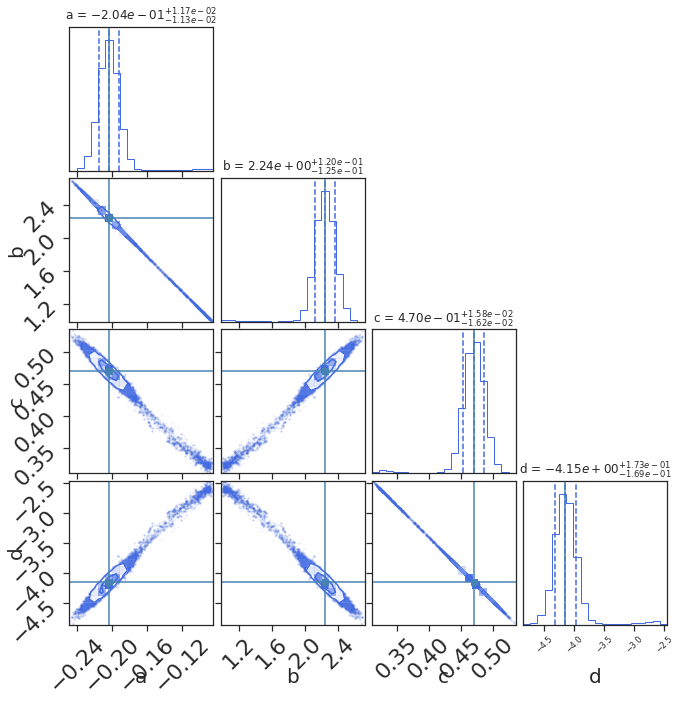

In [17]:
labels = ['a','b','c','d']
fig = corner.corner(samples,labels = labels,\
                    quantiles=[0.16,0.5,0.84],truths = para0,\
                   show_titles = True,title_kwargs ={"fontsize":12},\
                   color = 'royalblue',label_kwargs={'fontsize':20},title_fmt='.2e')
plt.tick_params(axis='both',which = 'both',labelsize = 8)
# plt.savefig("/home/yunzheng/PAC_newtry/picture/normal_frac_fitting/1_para.pdf",dpi = 100)

Text(0.5, 0.98, '$0<z<0.2$')

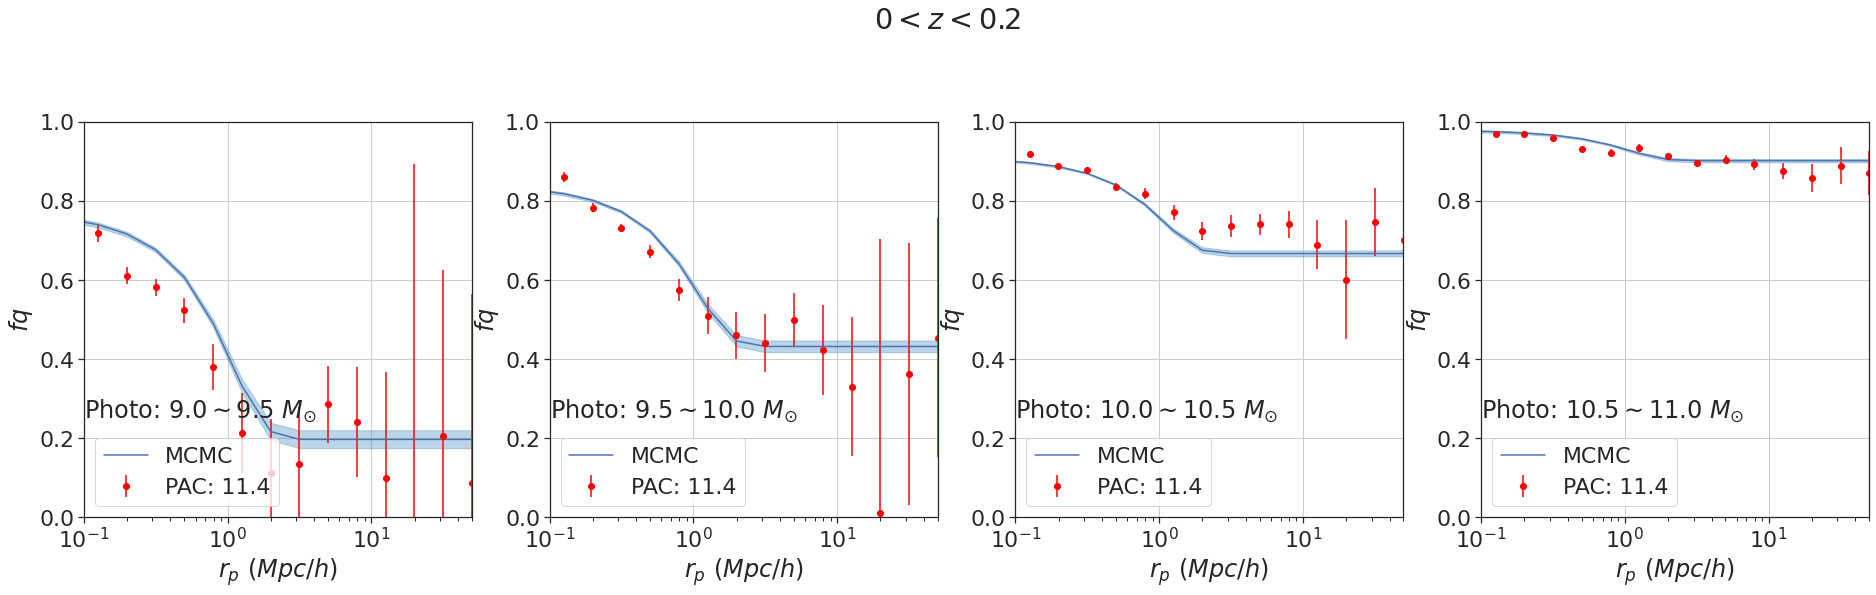

In [18]:
color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


plt.figure(figsize=(32,16))


k = 0
data = np.zeros((len(ms)-1,len(ml),3,16))
for i in range(len(ms)-1):
    for j in range(len(ml)):
        k = k+1
        plt.subplot(2,4,k)
        
        if j==0:
            red = np.load("./normal_fra_red_new_cor/%.1f_%.1f.npy"% (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))


        else:
            red = np.load("./normal_fra_red_cor/%.1f_%.1f.npy" % (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))



#         print("The para:",*popt)
        plt.plot(red[0],func((red[0],mass0[j]),para0[0],para0[1],para0[2],para0[3]),label = 'MCMC')
#         plt.plot(red[0],func((red[0],mass0[j]),low[0],low[1],low[2],low[3]))
#         plt.plot(red[0],func((red[0],mass0[j]),high[0],high[1],high[2],high[3]))

        err_res = np.zeros((16,92800))
        for ind in range(16):
            err_res[ind] = func((red[0][ind],mass0[j][0]),samples[:,0],samples[:,1],samples[:,2],samples[:,3])

        low = np.percentile(err_res,[16],axis = 1)
        high = np.percentile(err_res,[84],axis = 1)

        plt.fill_between(red[0],low[0],\
                        high[0],alpha = 0.3,color = color[0])

        plt.text(0.1,0.25,'Photo: %.1f$\sim$%.1f $M_{\odot}$' % (ml[j],ml[j]+0.5))


        plt.xscale('log')
        plt.ylim(0.0,1)
        plt.xlim(0.1,50)
        plt.xlabel("$r_p\ (Mpc/h)$")
        plt.ylabel('$fq$')
        plt.legend(loc='lower left')
        plt.grid()
plt.suptitle("$0<z<0.2$")
# plt.savefig("/home/yunzheng/PAC_newtry/picture/normal_frac_fitting/1_fqresult_error.pdf",dpi = 100)

Text(0.5, 0.98, '$0<z<0.2$')

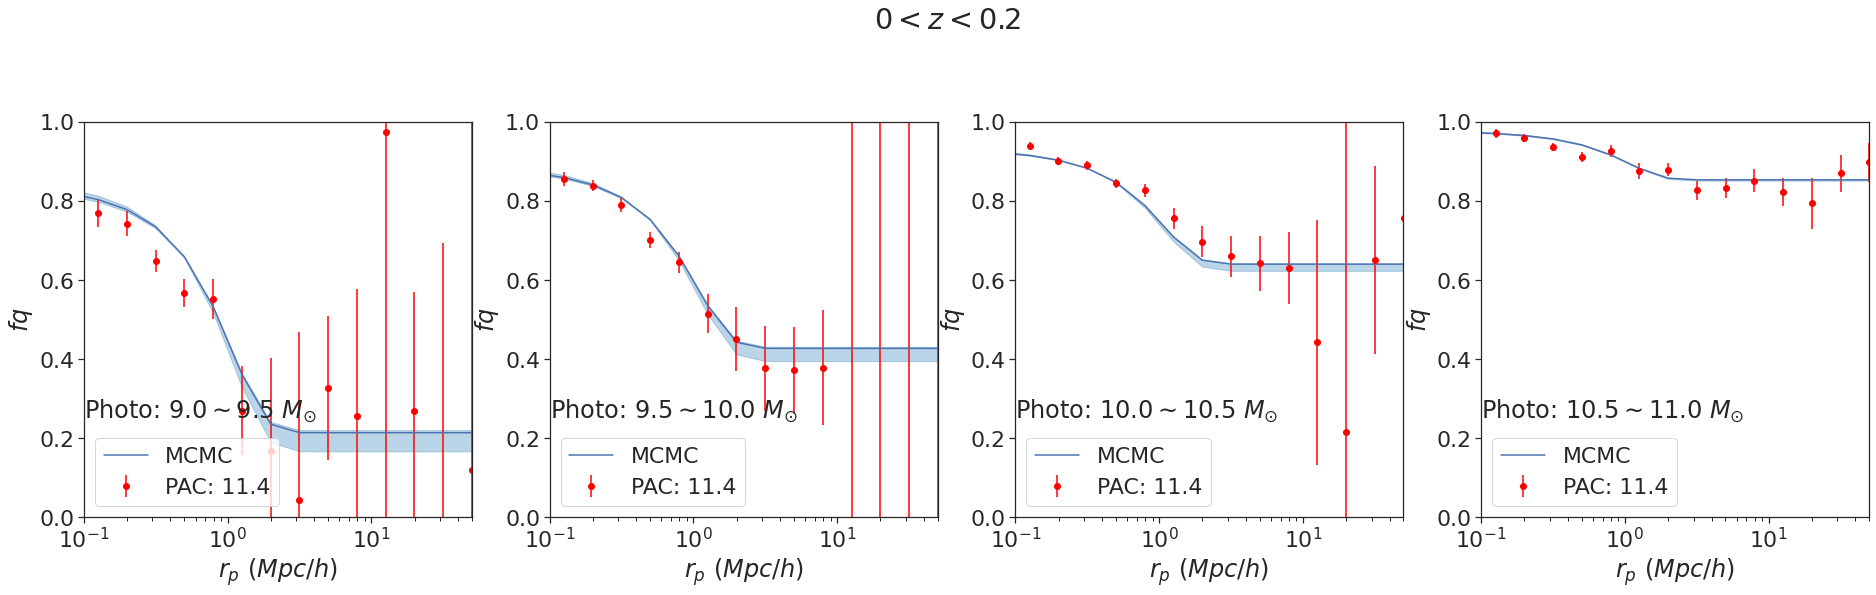

In [44]:
color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


plt.figure(figsize=(32,16))


k = 0
data = np.zeros((len(ms)-1,len(ml),3,16))
for i in range(len(ms)-1):
    for j in range(len(ml)):
        k = k+1
        plt.subplot(2,4,k)
        
        if j==0:
            red = np.load("./normal_fra_red_new_cor/%.1f_%.1f.npy"% (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))


        else:
            red = np.load("./normal_fra_red_cor/%.1f_%.1f.npy" % (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))



#         print("The para:",*popt)
        plt.plot(red[0],func((red[0],mass0[j]),para0[0],para0[1],para0[2],para0[3]),label = 'MCMC')
#         plt.plot(red[0],func((red[0],mass0[j]),low[0],low[1],low[2],low[3]))
#         plt.plot(red[0],func((red[0],mass0[j]),high[0],high[1],high[2],high[3]))

        plt.fill_between(red[0],func((red[0],mass0[j]),low[0],low[1],low[2],low[3]),\
                        func((red[0],mass0[j]),high[0],high[1],high[2],high[3]),alpha = 0.3,color = color[0])
        plt.text(0.1,0.25,'Photo: %.1f$\sim$%.1f $M_{\odot}$' % (ml[j],ml[j]+0.5))


        plt.xscale('log')
        plt.ylim(0.0,1)
        plt.xlim(0.1,50)
        plt.xlabel("$r_p\ (Mpc/h)$")
        plt.ylabel('$fq$')
        plt.legend(loc='lower left')
plt.suptitle("$0<z<0.2$")
# plt.savefig("/home/yunzheng/PAC_final/picture/normal_frac_fitting/1_114_fqresult.pdf",dpi = 100)

Text(0.5, 0.98, '$0<z<0.2$')

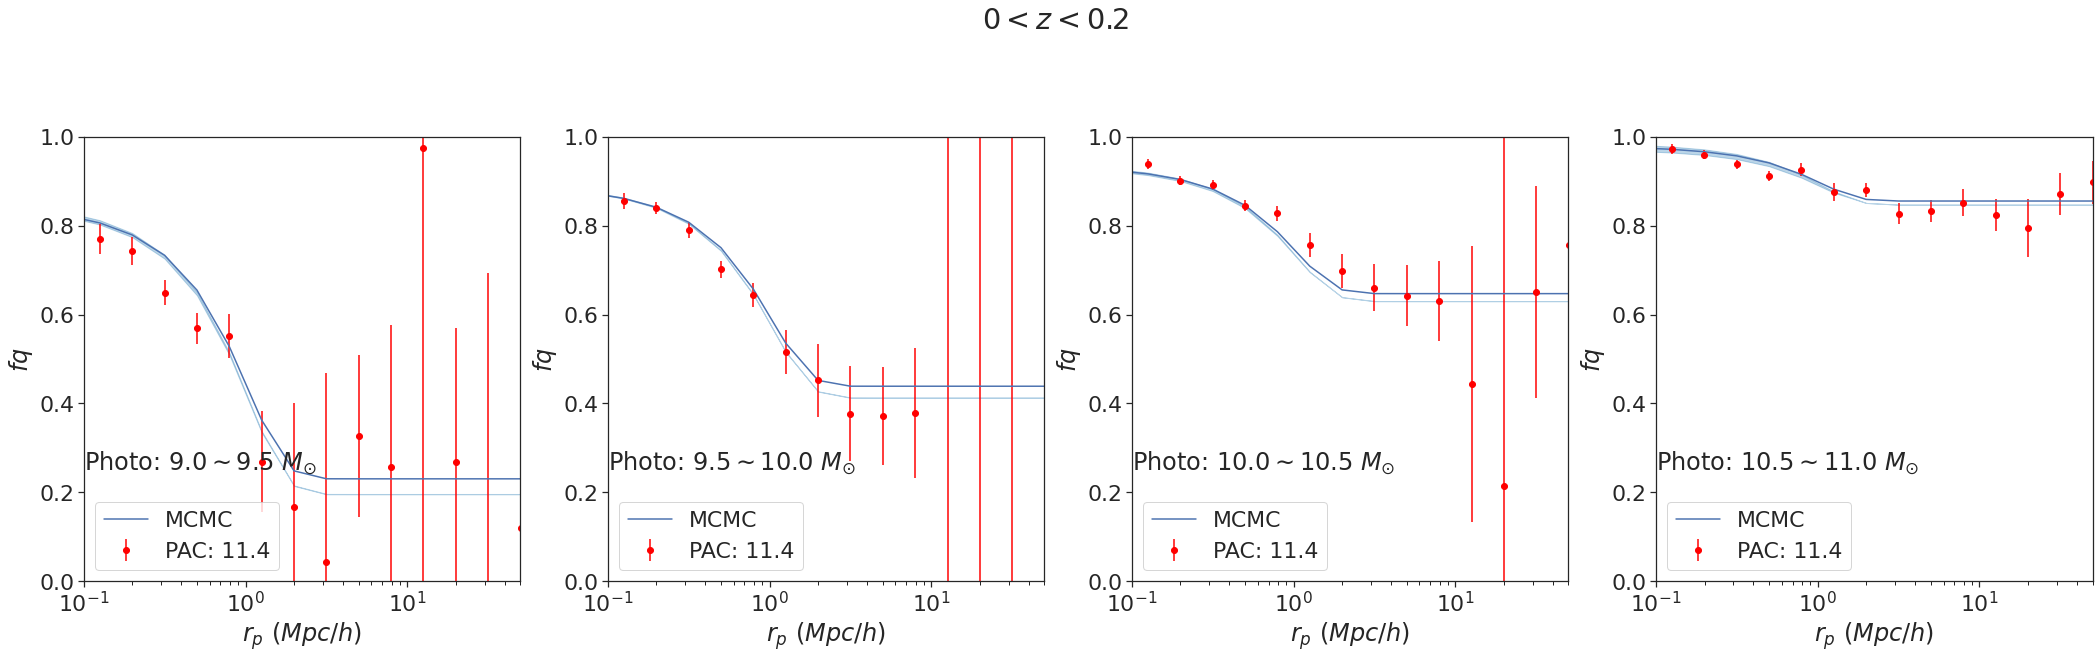

In [123]:
color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


plt.figure(figsize=(36,18))


k = 0
data = np.zeros((len(ms)-1,len(ml),3,16))
for i in range(len(ms)-1):
    for j in range(len(ml)):
        k = k+1
        plt.subplot(2,4,k)
        
        if j==0:
            red = np.load("./normal_fra_red_new_cor/%.1f_%.1f.npy"% (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))


        else:
            red = np.load("./normal_fra_red_cor/%.1f_%.1f.npy" % (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))



#         print("The para:",*popt)
        plt.plot(red[0],func((red[0],mass0[j]),para0[0],para0[1],para0[2],para0[3]),label = 'MCMC')
#         plt.plot(red[0],func((red[0],mass0[j]),low[0],low[1],low[2],low[3]))
#         plt.plot(red[0],func((red[0],mass0[j]),high[0],high[1],high[2],high[3]))

        plt.fill_between(red[0],func((red[0],mass0[j]),low[0],low[1],low[2],low[3]),\
                        func((red[0],mass0[j]),high[0],high[1],high[2],high[3]),alpha = 0.3,color = color[0])
        plt.text(0.1,0.25,'Photo: %.1f$\sim$%.1f $M_{\odot}$' % (ml[j],ml[j]+0.5))


        plt.xscale('log')
        plt.ylim(0.0,1)
        plt.xlim(0.1,50)
        plt.xlabel("$r_p\ (Mpc/h)$")
        plt.ylabel('$fq$')
        plt.legend(loc='lower left')
plt.suptitle("$0<z<0.2$")
# plt.savefig("/home/yunzheng/PAC_final/picture/normal_frac_fitting/1_114_fqresult.pdf",dpi = 100)

Text(0.5, 0.98, '$0<z<0.2$')

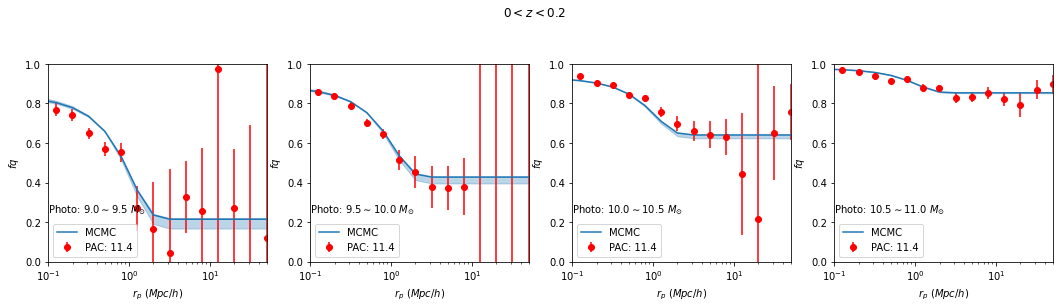

In [21]:
color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


plt.figure(figsize=(18,8))


k = 0
data = np.zeros((len(ms)-1,len(ml),3,16))
for i in range(len(ms)-1):
    for j in range(len(ml)):
        k = k+1
        plt.subplot(2,4,k)
        
        if j==0:
            red = np.load("./normal_fra_red_new_cor/%.1f_%.1f.npy"% (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))


        else:
            red = np.load("./normal_fra_red_cor/%.1f_%.1f.npy" % (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))



#         print("The para:",*popt)
        plt.plot(red[0],func((red[0],mass0[j]),para0[0],para0[1],para0[2],para0[3]),label = 'MCMC')
#         plt.plot(red[0],func((red[0],mass0[j]),low[0],low[1],low[2],low[3]))
#         plt.plot(red[0],func((red[0],mass0[j]),high[0],high[1],high[2],high[3]))

        plt.fill_between(red[0],func((red[0],mass0[j]),low[0],low[1],low[2],low[3]),\
                        func((red[0],mass0[j]),high[0],high[1],high[2],high[3]),alpha = 0.3,color = color[0])
        plt.text(0.1,0.25,'Photo: %.1f$\sim$%.1f $M_{\odot}$' % (ml[j],ml[j]+0.5))


        plt.xscale('log')
        plt.ylim(0.0,1)
        plt.xlim(0.1,50)
        plt.xlabel("$r_p\ (Mpc/h)$")
        plt.ylabel('$fq$')
        plt.legend(loc='lower left')
plt.suptitle("$0<z<0.2$")
# plt.savefig("/home/yunzheng/PAC_final/picture/normal_frac_fitting/1_114_fqresult.pdf",dpi = 100)

Text(0.5, 0.98, '$0<z<0.2$')

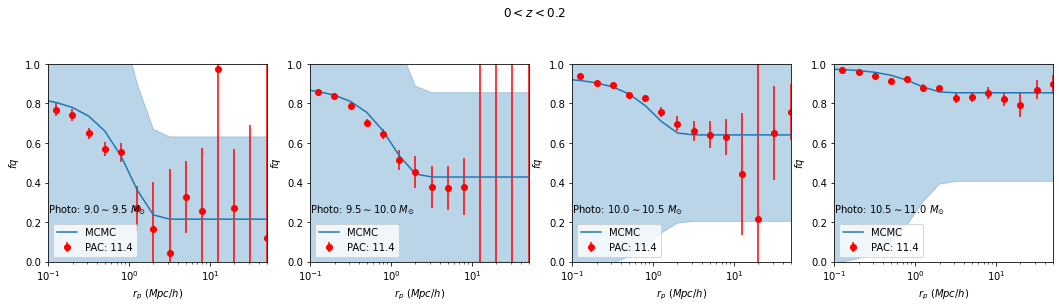

In [30]:
color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


plt.figure(figsize=(18,8))


k = 0
data = np.zeros((len(ms)-1,len(ml),3,16))
for i in range(len(ms)-1):
    for j in range(len(ml)):
        k = k+1
        plt.subplot(2,4,k)
        
        if j==0:
            red = np.load("./normal_fra_red_new_cor/%.1f_%.1f.npy"% (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))


        else:
            red = np.load("./normal_fra_red_cor/%.1f_%.1f.npy" % (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))



#         print("The para:",*popt)
        plt.plot(red[0],func((red[0],mass0[j]),para0[0],para0[1],para0[2],para0[3]),label = 'MCMC')
#         plt.plot(red[0],func((red[0],mass0[j]),low[0],low[1],low[2],low[3]))
#         plt.plot(red[0],func((red[0],mass0[j]),high[0],high[1],high[2],high[3]))

        plt.fill_between(red[0],func((red[0],mass0[j]),low[0],low[1],low[2],low[3]),\
                        func((red[0],mass0[j]),high[0],high[1],high[2],high[3]),alpha = 0.3,color = color[0])
        plt.text(0.1,0.25,'Photo: %.1f$\sim$%.1f $M_{\odot}$' % (ml[j],ml[j]+0.5))


        plt.xscale('log')
        plt.ylim(0.0,1)
        plt.xlim(0.1,50)
        plt.xlabel("$r_p\ (Mpc/h)$")
        plt.ylabel('$fq$')
        plt.legend(loc='lower left')
plt.suptitle("$0<z<0.2$")
# plt.savefig("/home/yunzheng/PAC_final/picture/normal_frac_fitting/1_114_fqresult.pdf",dpi = 100)

Text(0.5, 0.98, '$0<z<0.2$')

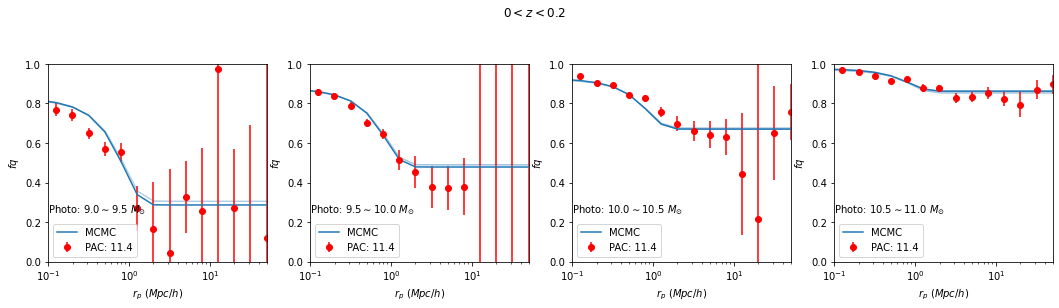

In [49]:
color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


plt.figure(figsize=(18,8))


k = 0
data = np.zeros((len(ms)-1,len(ml),3,16))
for i in range(len(ms)-1):
    for j in range(len(ml)):
        k = k+1
        plt.subplot(2,4,k)
        
        if j==0:
            red = np.load("./normal_fra_red_new_cor/%.1f_%.1f.npy"% (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))


        else:
            red = np.load("./normal_fra_red_cor/%.1f_%.1f.npy" % (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))



#         print("The para:",*popt)
        plt.plot(red[0],func((red[0],mass0[j]),para0[0],para0[1],para0[2],para0[3]),label = 'MCMC')
#         plt.plot(red[0],func((red[0],mass0[j]),low[0],low[1],low[2],low[3]))
#         plt.plot(red[0],func((red[0],mass0[j]),high[0],high[1],high[2],high[3]))

        plt.fill_between(red[0],func((red[0],mass0[j]),low[0],low[1],low[2],low[3]),\
                        func((red[0],mass0[j]),high[0],high[1],high[2],high[3]),alpha = 0.3,color = color[0])
        plt.text(0.1,0.25,'Photo: %.1f$\sim$%.1f $M_{\odot}$' % (ml[j],ml[j]+0.5))


        plt.xscale('log')
        plt.ylim(0.0,1)
        plt.xlim(0.1,50)
        plt.xlabel("$r_p\ (Mpc/h)$")
        plt.ylabel('$fq$')
        plt.legend(loc='lower left')
plt.suptitle("$0<z<0.2$")
# plt.savefig("/home/yunzheng/PAC_final/picture/normal_frac_fitting/1_114_fqresult.pdf",dpi = 100)

Text(0.5, 0.98, '$0<z<0.2 \\ Blue$')

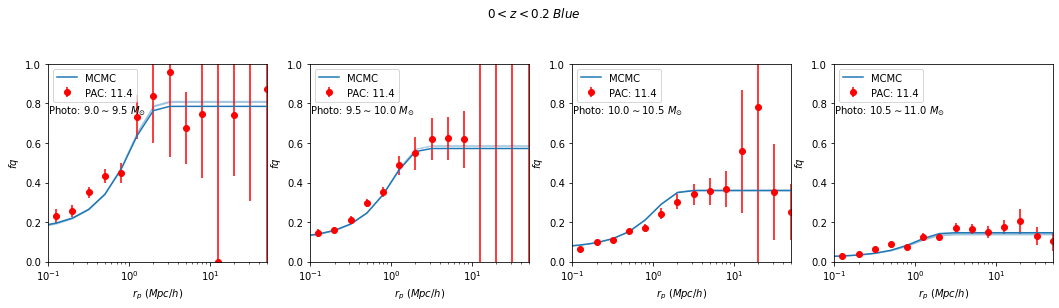

In [27]:
color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


plt.figure(figsize=(18,8))

# k = 0
# data = np.zeros((len(ms)-1,len(ml),3,16))
# for i in range(len(ms)-1):
#     for j in range(len(ml)):
#         k = k+1
#         plt.subplot(2,4,k)
#         red = np.load("./normal_fra_red/%.1f_%.1f.npy" % (ms[i]+0.1,ml[j]))
# #         plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))
#         data[i][j] = red
# # blue = np.load("./normal_fra_blue_cor/%.1f_%.1f.npy" % (11.4,10.0))
# # # plt.errorbar(blue[0],blue[1],blue[2],fmt='o',color='blue',label='PAC: %.1f' % (ms[i]+0.1))


# rtest = np.concatenate((data[0][::,0]))
# datatest = np.concatenate((data[0][::,1]))
# sigtest = np.concatenate((data[0][::,2]))
# masstest = np.concatenate((mass0))
# # popt,pcov = curve_fit(func,(rtest,masstest),datatest,sigma = sigtest,p0=(-0.00357,1,1.0,1))
# # print("The fitting result:",popt)

k = 0
data = np.zeros((len(ms)-1,len(ml),3,16))
for i in range(len(ms)-1):
    for j in range(len(ml)):
        k = k+1
        plt.subplot(2,4,k)
        
        if j==0:
            red = np.load("./normal_fra_blue_new_cor/%.1f_%.1f.npy"% (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))


        else:
            red = np.load("./normal_fra_blue_cor/%.1f_%.1f.npy" % (ms[i]+0.1,ml[j]))
            plt.errorbar(red[0],red[1],red[2],fmt='o',color='red',label='PAC: %.1f' % (ms[i]+0.1))



#         print("The para:",*popt)
        plt.plot(red[0],1-func((red[0],mass0[j]),para0[0],para0[1],para0[2],para0[3]),label = 'MCMC')
#         plt.plot(red[0],func((red[0],mass0[j]),low[0],low[1],low[2],low[3]))
#         plt.plot(red[0],func((red[0],mass0[j]),high[0],high[1],high[2],high[3]))

        plt.fill_between(red[0],1-func((red[0],mass0[j]),low[0],low[1],low[2],low[3]),\
                        1-func((red[0],mass0[j]),high[0],high[1],high[2],high[3]),alpha = 0.3,color = color[0])
        plt.text(0.1,0.75,'Photo: %.1f$\sim$%.1f $M_{\odot}$' % (ml[j],ml[j]+0.5))


        plt.xscale('log')
        plt.ylim(0.0,1)
        plt.xlim(0.1,50)
        plt.xlabel("$r_p\ (Mpc/h)$")
        plt.ylabel('$fq$')
        plt.legend(loc='upper left')
plt.suptitle("$0<z<0.2 \ Blue$")
# plt.savefig("/home/yunzheng/PAC_final/picture/normal_frac_fitting/1_114_fqresult_blue.pdf",dpi = 100)